# Human Resources Analytics : Exploration Data Analysis and modeling

* **1 Introduction**
* **2 Load and check data**
    * 2.1 load data
    * 2.2 check for missing values
* **3 Global data exploration**
* **4 Detailed data exploration**    
    * 4.1 Normalisation and dimensionalty reduction
    * 4.2 Global Radar Chart
    * 4.3 Left and other features
    * 4.4 Clustering analysis
* **5 Modeling**
    * 5.1 Decision Tree
    * 5.2 Random Forest

## 1. Introduction

The Human Resources Analytics is a dataset providing informations on the situation and work of several ten of thousands employees.

**In this kernel ill focus on one very important question : Why employees are leaving the company ?**

To tackle this question , this notebook combines data exploration analysis and modeling.

This dataset is perfect for this kind of detailed data exploration because it contains a few number of features a large number of individual, so we can perform robust statistics. Firstlty, ill globally explore the dataset, then ill focus on a detailed exploration analysis of the stayed/left employees and ill end by the data modeling.

This script follows three main parts:

* **Global data exploration**
* **Detailed data exploration**
* **Data modeling**

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
#import pydot
#import pydotplus as pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()

import warnings

#warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', '.*')

sns.set(style='white', context='notebook', palette='deep')

np.random.seed(seed=2)

Loading BokehJS ...

## 2. Load and Check data
### 2.1 Load the data

In [4]:
# Load the data
dataset = pd.read_csv("/home/azureuser/HRAnalytics/HR_comma_sep.csv")

In [5]:
dataset.shape

(14999, 10)

In [6]:
# Look at the train set
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


- This dataset contains 14999 rows described by 10 features.


- There are 8 numerical features and 2 categorical features.
    - Sales is non nominal
    - Salary is ordinal
    
    
    
- The feature of our interests is the 'left' feature, it encoded in {0,1} 0 for stayed employees and 1 if not.

### 2.2 check for missing values

In [7]:
# Check for missing values
dataset.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

The dataset is already clean, there is no missing values at all , great  !!!

## 3. Global data exploration

Here, i display histograms of the 10 features for a global analysis.

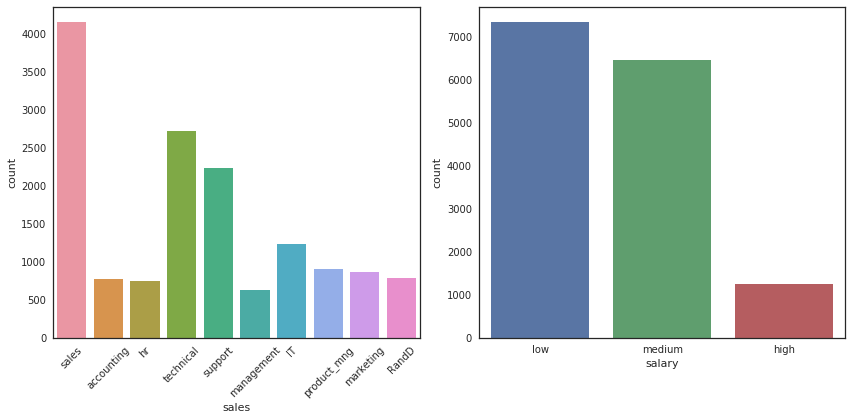

In [8]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
g = sns.countplot(dataset["sales"], ax=axs[0])
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.countplot(dataset["salary"], ax=axs[1])
plt.tight_layout()
plt.show()
plt.gcf().clear()

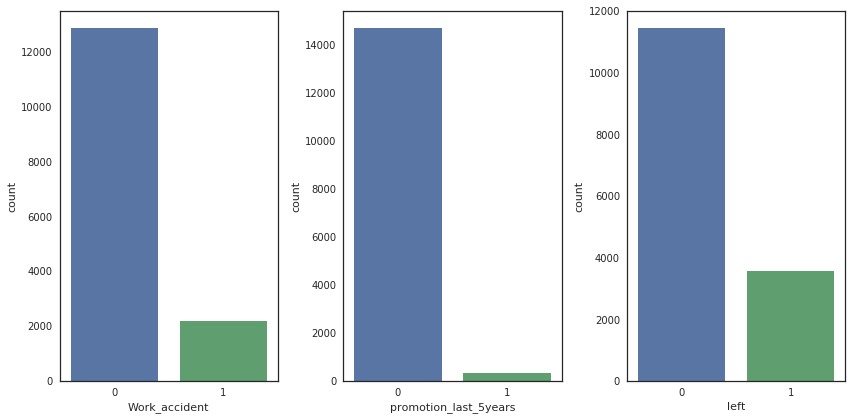

In [9]:
fig, axs = plt.subplots(ncols=3,figsize=(12,6))
sns.countplot(dataset["Work_accident"], ax=axs[0])
sns.countplot(dataset["promotion_last_5years"], ax=axs[1])
sns.countplot(dataset["left"], ax=axs[2])
plt.tight_layout()
plt.show()
plt.gcf().clear()

- Our target variable (left) is unbalanced, since we have not more than 10x it is still reasonable.

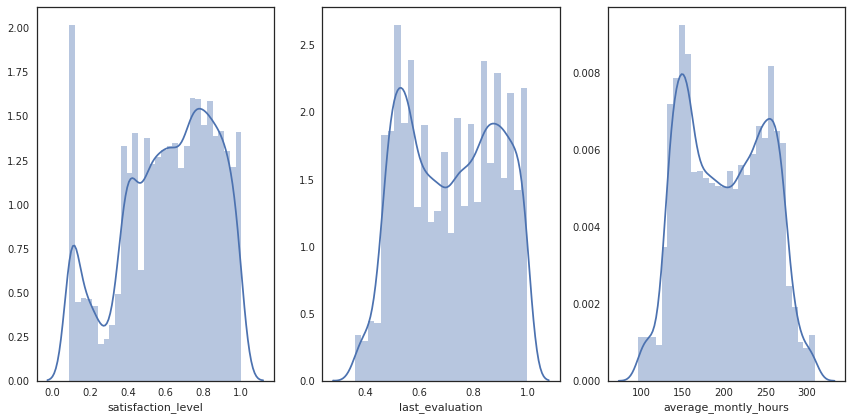

In [10]:
fig, axs = plt.subplots(ncols=3,figsize=(12,6))
sns.distplot(dataset["satisfaction_level"], ax=axs[0])
sns.distplot(dataset["last_evaluation"], ax=axs[1])
sns.distplot(dataset["average_montly_hours"], ax=axs[2])
plt.tight_layout()
plt.show()
plt.gcf().clear()

These distplots show something very interesting. It seems that there is two distributions mixed in satisfaction_level, last_evaluation and average_montly_hours data distributions. 

**Is that corresponding to employees who stay and left ?**

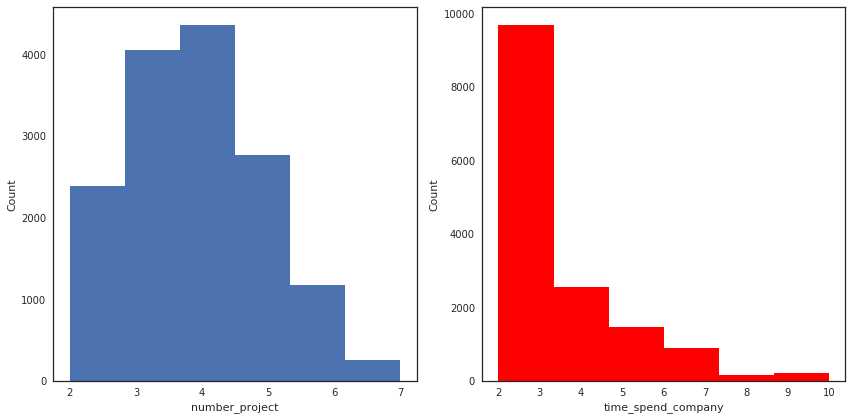

In [11]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
axs[0].hist(dataset["number_project"],bins=6)
axs[0].set_xlabel("number_project")
axs[0].set_ylabel("Count")
axs[1].hist(dataset["time_spend_company"],bins=6,color="r")
axs[1].set_xlabel("time_spend_company")
axs[1].set_ylabel("Count")
plt.tight_layout()
plt.show()
plt.gcf().clear()

The number of projects and the time spend in company seem to follow an extrem value distribution (Gumbel distribution).

Time_spend_company is very positively skewed (right skewed).

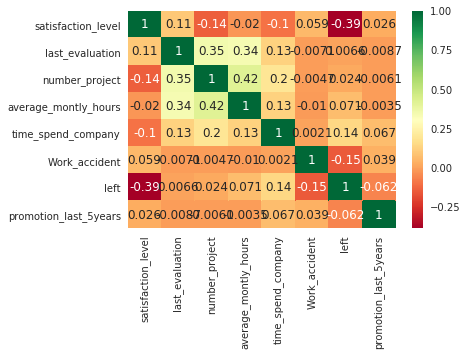

In [12]:
g = sns.heatmap(dataset.corr(),annot=True,cmap="RdYlGn")

It seems that employees working hard and with many projects have a better evaluation. (corr(number_project,last_evaluation) : 0.35, corr(average_montly_hours,last_evaluation) : 0.34 ).

The most important thing in this correlation matrix is the negative correlation between 'left' and 'satifaction_level' (-0.39) : **employees leave because they are not happy at work ?**

**Is that the only main reason ?**
**Is there employee patterns that can explained that ?** 

To adress these questions, i performed a detailed analysis.

## 4. Detailed data exploration

Firslty, i will perform a dimensionality reduction in order to identify groups.

In [13]:
dataset = dataset.drop(labels=["sales"],axis = 1)

In [14]:
dataset["salary"] = dataset["salary"].astype("category",ordered=True, categories = ['low','medium','high']).cat.codes

### 4.1 Normalisation and dimensionalty reduction

In [15]:
# pca/isomap analysis

N = StandardScaler()

N.fit(dataset)

dataset_norm = N.transform(dataset)

Don't forget to normalize the data before the demensionality reduction.

In [16]:
index = np.random.randint(0,dataset_norm.shape[0],size=10000)

Because of the size of the dataset the isomap algorithm is very memory greedy. So i randomly choosed a 10 000 points in the dataset. 

The isomap and pca maps are very similar to the ones obtained from the full dataset and are much faster to compute.

In [17]:
pca = PCA(n_components=2)
pca_representation = pca.fit_transform(dataset_norm[index])

In [18]:
iso = Isomap(n_components=2, n_neighbors=40)
iso_representation = iso.fit_transform(dataset_norm[index])

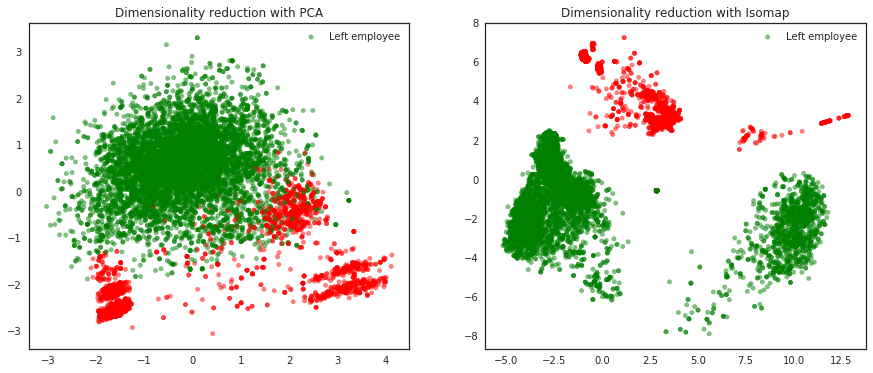

In [19]:
left_colors = dataset["left"].map(lambda s : "g" if s==0 else "r")

fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].scatter(pca_representation[:,0],pca_representation[:,1],
            c = left_colors[index],alpha=0.5,s=20)
axes[0].set_title("Dimensionality reduction with PCA")
axes[0].legend(["Left employee"])

axes[1].scatter(iso_representation[:,0],iso_representation[:,1],
            c = left_colors[index],alpha=0.5,s=20)
axes[1].set_title("Dimensionality reduction with Isomap")
axes[1].legend(["Left employee"])


The red points correspond to employees who left. Here the PCA doesn't show a great separation between the left and stayed employees. PCA performs a linear demensionality reduction , the components produced by pca is a linear combinaison of the existing features. So it is very good when we have a linear relation between the points.

Here it seems that we need a non linear reduction like isomap does. We can see a great separation between the red and green points. An interesting fact is that we have two groups of employees who stayed (green points).

**Let's represent this with an interactive plot**

In [20]:
source_dataset = ColumnDataSource(
        data = dict(
            x = iso_representation[:2000,0],
            y = iso_representation[:2000,1],
            desc = dataset.loc[index,"left"],
            colors = ["#%02x%02x%02x" % (int(c*255), int((1-c)*255), 0) 
            for c in dataset.loc[index,"left"]],
            satisfaction_level = dataset.loc[index,'satisfaction_level'],
            last_evaluation = dataset.loc[index,'last_evaluation'],
            number_project = dataset.loc[index,'number_project'],
            time_spend_company = dataset.loc[index,'time_spend_company'],
            average_montly_hours = dataset.loc[index,'average_montly_hours']))
        
hover = HoverTool(tooltips=[("Left", "@desc"), 
                       ("Satisf. level", "@satisfaction_level"),
                       ("#projects", "@number_project"), 
                       ("Last eval.", "@last_evaluation"),
                       ("Time in Company", "@time_spend_company"),
                       ("Montly hrs", "@average_montly_hours")])

tools_isomap = [hover, "box_zoom",'pan', 'wheel_zoom', 'reset']

plot_isomap = figure(plot_width= 800, plot_height=600, tools=tools_isomap, 
                     title='Isomap projection of employee data')
plot_isomap.scatter('x', 'y', size=7, fill_color = "colors", line_color = None,
                    fill_alpha = 0.6, radius=0.1, alpha=0.5, line_width=0,
                    source=source_dataset)
show(plot_isomap)

You can hover the data to see the major features. 

### 4.2 Global Radar Chart

In [21]:
data_stay = dataset[dataset["left"]==0]
data_left = dataset[dataset["left"]==1]

For practical reasons, i separate the left and stay data.

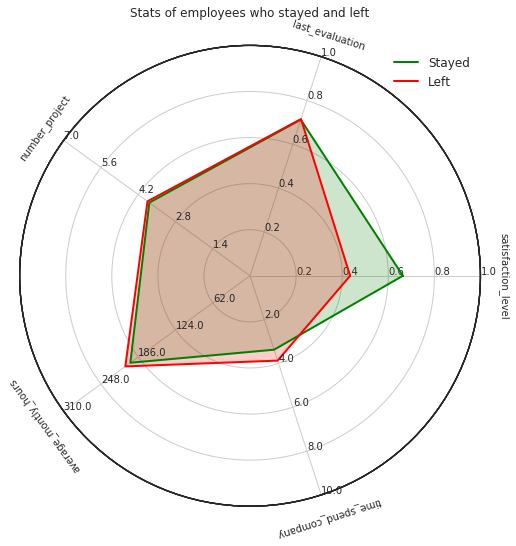

In [22]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart():
    def __init__(self, fig, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.8,0.8],polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.1f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)


attributes = ['satisfaction_level','last_evaluation','number_project',
              'average_montly_hours','time_spend_company']



data_stay_mean = data_stay[attributes].mean().values.reshape(1,-1)
data_left_mean = data_left[attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_stay_mean,data_left_mean),axis = 0)

ranges = [[1e-2, dataset[attr].max()] for attr in attributes]
colors = ["green","red"]
left_types = ["Stayed","Left"]


fig = plt.figure(figsize=(8, 8))
radar = RadarChart(fig, attributes, ranges)

for data, color, left_type in zip(datas, colors, left_types):
    radar.plot(data, color = color, label = left_type, linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = color)
    radar.legend(loc = 1, fontsize = 'medium')

plt.title('Stats of employees who stayed and left')
plt.show()

This radar chart doesn't show so many diffrences between left and stayed employees. At first glance the main difference seems to be the satisfaction level. 

As we demonstrate above, employees who left are less happy than the others.

However this radar chart is build on the mean of each feature, so it could hide some sub-distributions in the data. 

Let's investigate this in further analysis.

### 4.3 Left and other features

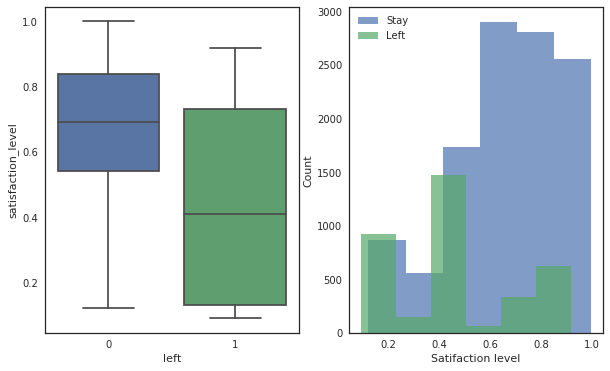

In [23]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.factorplot(y="satisfaction_level",x="left",data=dataset,kind="box", ax=axs[0])
axs[1].hist(data_stay["satisfaction_level"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["satisfaction_level"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Satifaction level")
axs[1].set_ylabel("Count")
axs[1].legend()
plt.tight_layout()
plt.gcf().clear()

The satisfaction level is the most correlated feature with 'left'. Here we can see that employees who left have a lower satisfaction level that those who stayed.

We can also noticed the three sub-distributions of satisfaction levels with employees who left. Is that corresponding to 3 groups ?
- One with a low satisfaction level
- One with a medium satisfaction level
- One with a high satisfaction level

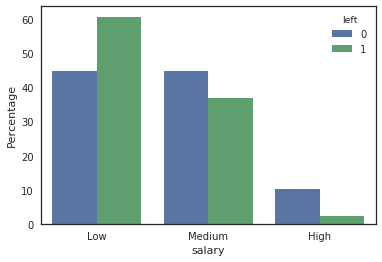

In [24]:
salary_counts = (dataset.groupby(['left'])['salary']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="salary", y="percentage", hue="left", data=salary_counts)
p.set_ylabel("Percentage")
p = p.set_xticklabels(["Low","Medium","High"])

Let's invistigate for the salary of employees who left/stayed.

Here i show the percentage of the employees with a low/medium/high salary in the two categories.

- Employees who left have a lower salary than other.

**Is that the reason why employees left ?**

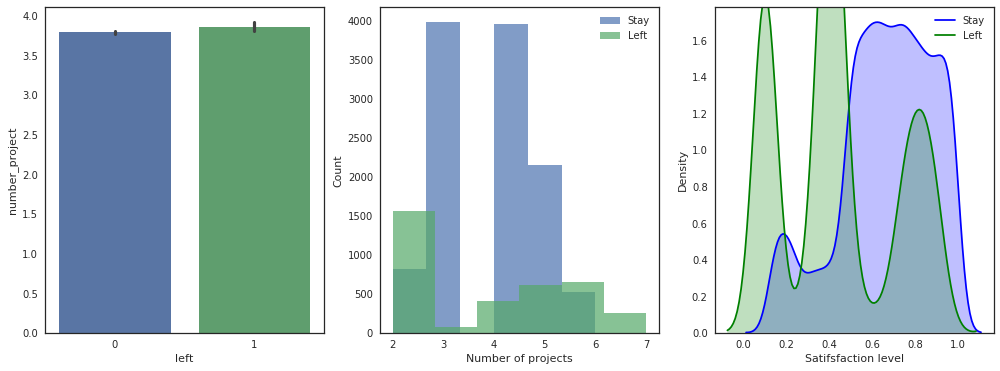

In [25]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(17,6))

sns.factorplot(y="number_project",x="left",data=dataset,kind="bar", ax=axs[0])

axs[1].hist(data_stay["number_project"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["number_project"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Number of projects")
axs[1].set_ylabel("Count")
axs[1].legend()

ax = sns.kdeplot(data=data_stay["satisfaction_level"],color='b',shade=True,ax=axs[2])
ax = sns.kdeplot(data=data_left["satisfaction_level"],color='g',shade=True, ax=axs[2])
ax.legend(["Stay","Left"])
ax.set_xlabel('Satifsfaction level')
ax.set_ylabel('Density')

plt.tight_layout()
plt.gcf().clear()

Let's see now if they have more work than the others. 

Left and stayed employees have a similar number of projects.

However, when we look in detail, there is two sub population in the employees who left. Those who have few projects and those who have a lot of projects.


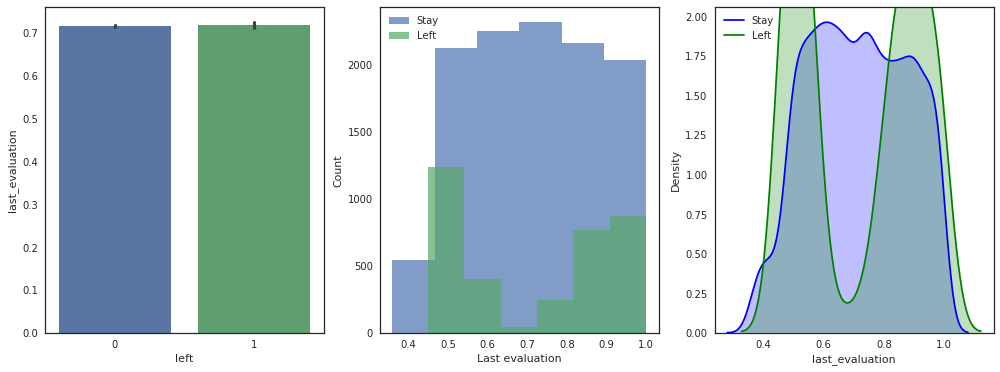

In [26]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(17,6))

sns.factorplot(y="last_evaluation",x="left",data=dataset,kind="bar", ax=axs[0])

axs[1].hist(data_stay["last_evaluation"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["last_evaluation"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Last evaluation")
axs[1].set_ylabel("Count")
axs[1].legend()

ax = sns.kdeplot(data=data_stay["last_evaluation"],color='b',shade=True, ax=axs[2])
ax = sns.kdeplot(data=data_left["last_evaluation"],color='g',shade=True, ax=axs[2])
ax.legend(["Stay","Left"])
ax.set_xlabel('last_evaluation')
ax.set_ylabel('Density')

plt.tight_layout()
plt.gcf().clear()

When we look at the last evaluation we still have two sub populations of left employees.

Those with a medium score and those with an high score, that's very interesting !

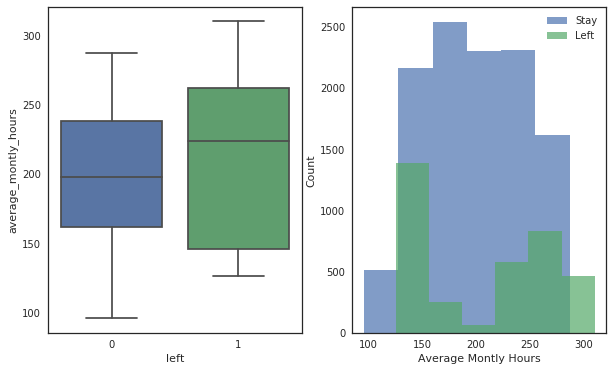

In [27]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.factorplot(y="average_montly_hours",x="left",data=dataset,kind="box", ax=axs[0])
axs[1].hist(data_stay["average_montly_hours"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["average_montly_hours"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Average Montly Hours")
axs[1].set_ylabel("Count")
axs[1].legend()
plt.tight_layout()
plt.gcf().clear()

Similarly to the evaluation score and the number of projects. There is two sub populations of employees who left. Those who work less and those who work a lot.

Since the evaluation score, the number of projects and the average montly hours are correlated each other, we can make the hypothesis that there is two groups of employee who leaves. Those who work less because they have gets lower scores 

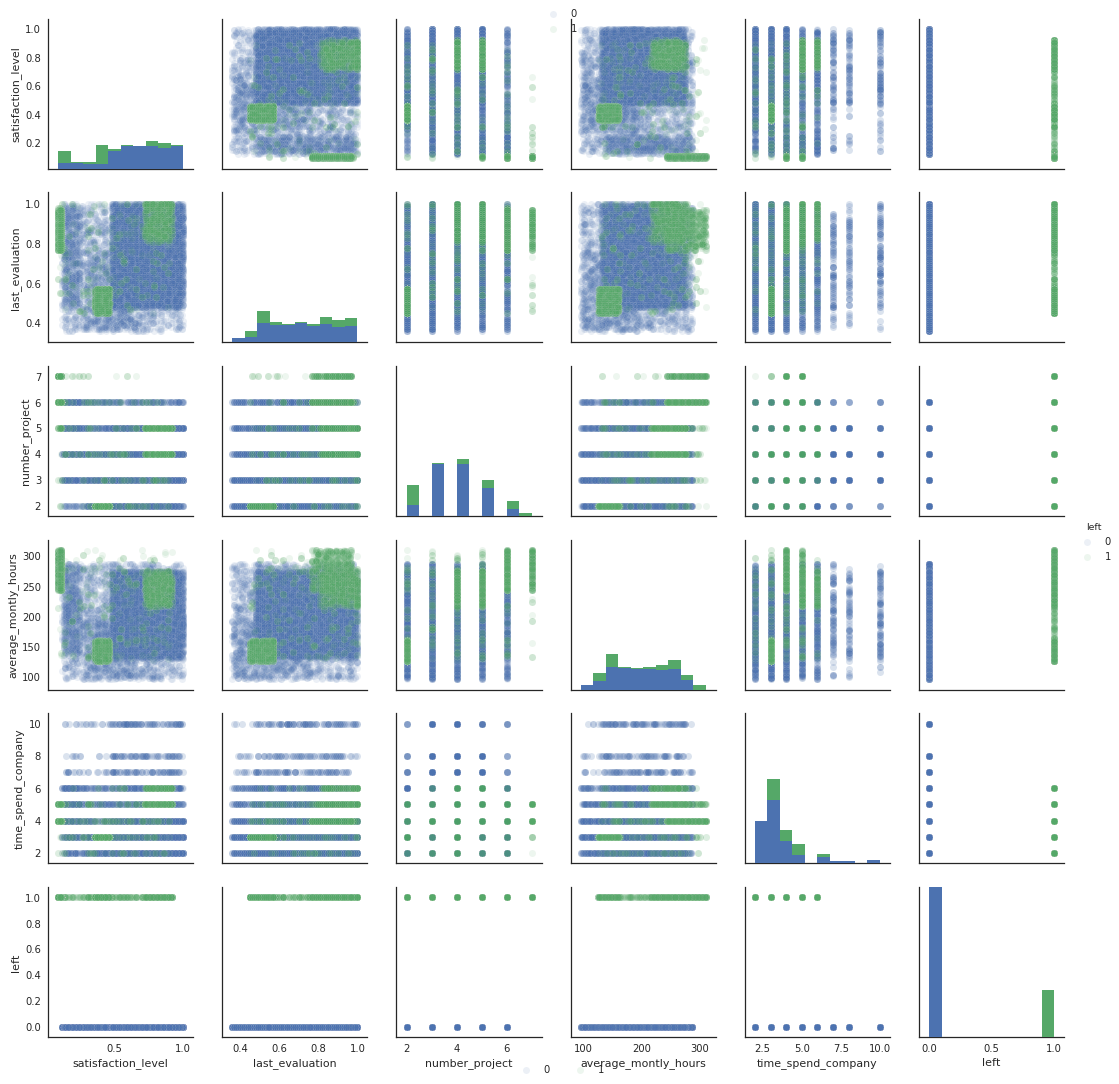

In [28]:
g = sns.pairplot(dataset.drop(labels=['promotion_last_5years','Work_accident','salary'],axis=1),hue="left",plot_kws=dict(alpha=0.1))
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)

The pairplot shows very interesting patterns when we plot the average montly hours against the satisfaction level or the satifaction level against the evaluation score.

It's like we still have 2/3 kind of employees who left.

Let's analyse these groups in detail.

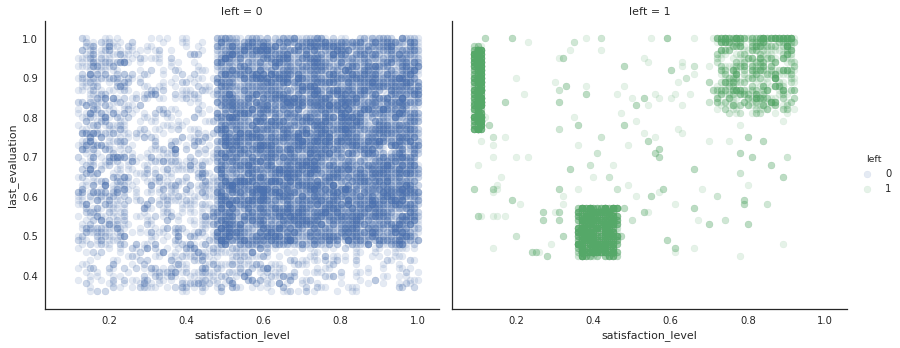

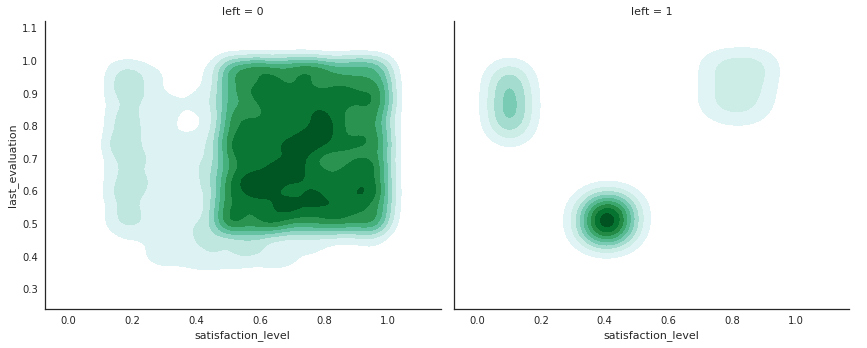

In [29]:
# Deeper in the analysis
g = sns.FacetGrid(dataset, col="left", hue="left",size=5,aspect=1.2)
g.map(plt.scatter, "satisfaction_level", "last_evaluation",alpha=0.15)
g.add_legend()

g = sns.FacetGrid(dataset, col="left",size=5,aspect=1.2)
g.map(sns.kdeplot, "satisfaction_level", "last_evaluation",shade=True,shade_lowest=False)
g.add_legend()

We have three groups of employees who left.
    - Successfull but unhappy employees (top left)
    - Successfull and happy employees (top right)
    - Unsuccessfull and unhappy employees (bottom center)
    
Now we want to label the data with this tree groups.

### 4.4 Clustering analysis

In [30]:
# Lets compare inside the 3 identified groups

kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(data_left[["satisfaction_level","last_evaluation"]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

I performed a kmean clustering to isolate these three groups.

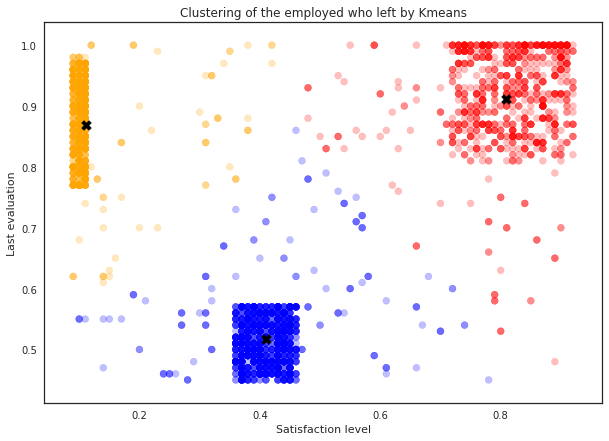

In [31]:
kmeans_colors = ['red' if c == 0 else 'orange' if c == 2 else 'blue' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 7))
plt.scatter(x="satisfaction_level",y="last_evaluation", data=data_left,
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction level")
plt.ylabel("Last evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clustering of the employed who left by Kmeans")

plt.show()

The cluster center are the three black crosses.

We have three groups which are defined as : 
    - SuccessUnhappy (yellow) == Successfull but unhappy employees (top left)
    - SuccessHappy (red) == Successfull and happy employees (top right)
    - UnsuccessUnhappy (blue) == Unsuccessfull and unhappy employees (bottom center)

In [32]:
data_left_SuccessHappy = data_left[kmeans.labels_ == 0]
data_left_UnsuccessUnhappy = data_left[kmeans.labels_ == 1]
data_left_SuccessUnhappy = data_left[kmeans.labels_ == 2]

In [33]:
data_left_SuccessUnhappy.shape

(944, 9)

In [34]:
data_left_SuccessHappy.shape

(977, 9)

In [35]:
data_left_UnsuccessUnhappy.shape

(1650, 9)

The three groups have sufficient data to consider significant differences.

To demonstrate a significant diffrence we should perform statistical analysis . Such as comparison of means (Student test,  Z-test or wilcoxon test if you don't want to make any assumption on the data distribution) 

In [36]:
data_left_SuccessUnhappy_mean = data_left_SuccessUnhappy[attributes].mean().values.reshape(1,-1)
data_left_SuccessHappy_mean = data_left_SuccessHappy[attributes].mean().values.reshape(1,-1)
data_left_UnsuccessUnhappy_mean = data_left_UnsuccessUnhappy[attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_stay_mean,data_left_SuccessUnhappy_mean, 
                        data_left_SuccessHappy_mean,data_left_UnsuccessUnhappy_mean),axis = 0)

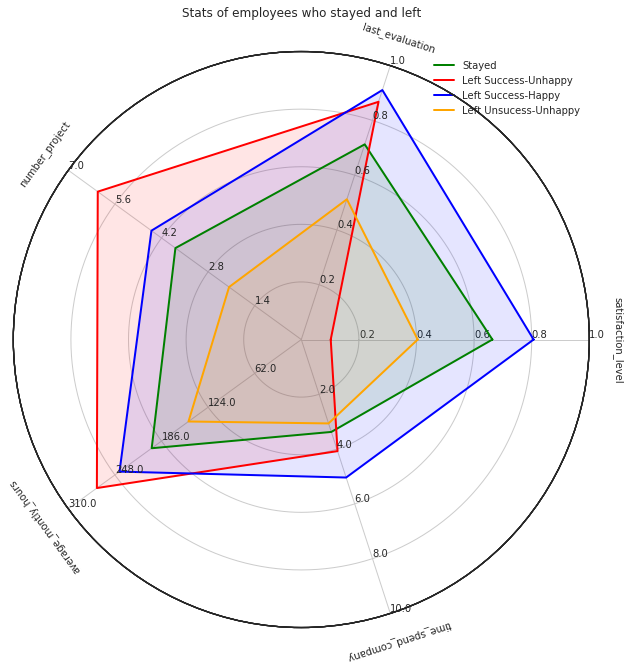

In [37]:
colors = ["green","red","blue","orange"]
left_types = ["Stayed","Left Success-Unhappy", "Left Success-Happy", "Left Unsucess-Unhappy"]

fig = plt.figure(figsize=(10, 10))
radar = RadarChart(fig, attributes, ranges)
for data, color, left_type in zip(datas, colors, left_types):
    radar.plot(data, color = color, label = left_type,linewidth=2.0)
    radar.fill(data, alpha = 0.1, color = color)
    radar.legend(loc = 1, fontsize = 'small')
plt.title('Stats of employees who stayed and left')
plt.show() 

When we compare the 3 groups and the group of employees who stayed we better understand the groups.

It appears that the SuccessUnhappy group of employees are those who work the most with 6 projects and more than 300 h/month.
These employees left because they have too much work !

The UnsuccessUnhappy group left because they are not really involved in their company. They have few projects and work less than the other.

The last group (SuccessHappy group) is closest to the stay group except that they spent a long time in the company.


## 5. Modeling

I wanted to build a model that predicts the target variable with a good accuracy and explore the features weights and importance.

In [38]:
## Prediction of the target variable (stay/left) 

X_train = dataset.drop(labels = "left",axis = 1)

Y_train = dataset["left"]

train_features = X_train.columns

In [39]:
kfold = StratifiedKFold(Y_train,n_folds=10,random_state=2)

### 5.1 Decision Tree
I will consider the Decision tree algorithm which is perfect for studying the importance of features in data modeling.

In [40]:
DTC = DecisionTreeClassifier(max_depth=3)

cv_results = cross_val_score(DTC,X_train, Y_train, cv=kfold, scoring="accuracy")

cv_results.mean()

0.95239079072183286

I have restricted the depth tree to 3, to build a simple tree for analysis.

Despite the simplicity of this tree, it gives us 95% of accuracy which is very good and enough.

In [41]:
DTC.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

I plot the tree structure to look at the most important features.

In [42]:
### NOT WORKING ON KAGGLE SERVERS (no module pydot nor pydotplus)####
#dot_data = StringIO()

#tree.export_graphviz(DTC, out_file=dot_data,feature_names=train_features)

#graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
#graph.set_lwidth(400)
#graph.set_lheight(300)

#Image(graph.create_png())

# I have uploaded an image instead.

![](http://img1.imagilive.com/0817/graph_DTC.png)

In the Decision tree structure, the most important variable (for the prediction) is at the top.

So the satisfaction level is the most important feature. 

What is very interesting is that we can found the 4 groups (SuccessHappy, UnsuccessUnhappy, SuccessUnhappy, stay) and their caracteristics .

- **The left leaf (satisf.level <=0.465 [True] -> number_project <= 2.5 [True] -> last_evaluation <= 0.57 [True]) corresponds to the UnsuccessUnhappy group.**


- **The path satisf.level <=0.465 [True] -> number_project <= 2.5 [False] -> last_evaluation <= 0.115 [True] corresponds to the SuccessUnhappy group.**


- **The right leaf (satisf.level <=0.465 [False] -> time_spend_company <= 4.5 [False] -> last_evaluation <= 0.805 [False])corresponds to the SuccessHappy group.**


- **The path (satisf.level <=0.465 [False] -> time_spend_company <= 4.5 [True] -> average_monty_hours <= 290.5 [True]) contains to the most important part of the stay group (8706/11428 = 76%).**

With this decision tree we can clearly explain why the employee left.

### 5.2 Random Forest
I made a Random Forest classifier for those who like the performances :) (99% of accuracy)

In [43]:
# For those who like performance, 99% accuracy

RFC = RandomForestClassifier()

cv_results = cross_val_score(RFC,X_train, Y_train, cv=kfold, scoring="accuracy")

cv_results.mean()

0.99140008877040986

In [44]:
RFC.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

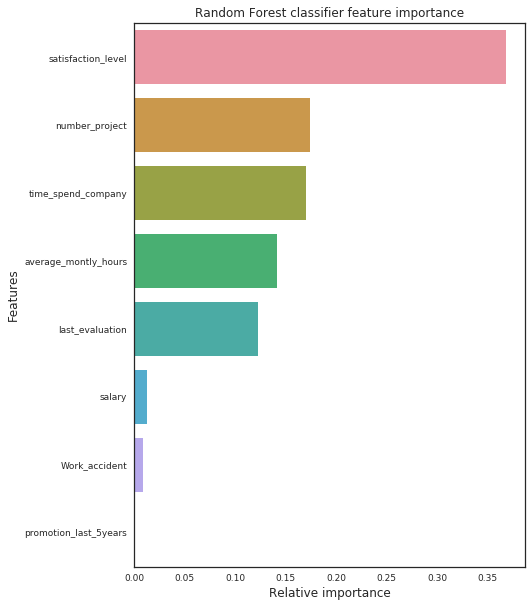

In [45]:
indices = np.argsort(RFC.feature_importances_)[::-1][:40]

fig = plt.figure(figsize=(7, 10))
g = sns.barplot(y=train_features[indices][:40],x = RFC.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Random Forest classifier feature importance")

plt.show()
plt.gcf().clear()

It is now clear that satisfaction_level average_montly_hours, number_project, time_spend_company and last_evaluation are the 5 most important features that explain why employees are leaving or staying in the company. Not the salary not the promotions.

## **I really enjoyed writing this kernel, and explain it. So if it is helpful for you (i hope) or you liked it (i hope too), some upvotes would be very much appreciated - That will keep me motivated :)**